In [0]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/

/content/gdrive


In [4]:
cd 'My Drive'/

/content/gdrive/My Drive


In [5]:
cd ImageColorization/

/content/gdrive/My Drive/ImageColorization


In [6]:
train_data = datasets.CIFAR10('CIFAR10', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)

Files already downloaded and verified


In [0]:
def real_data_target(size):
    return (torch.ones(size, 1, 3, 3)).to(device)

def fake_data_target(size):
    return (torch.zeros(size, 1, 3, 3)).to(device)

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")

Tesla P100-PCIE-16GB


In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #ENCODER
        
        self.convE1 = nn.Conv2d(1, 64, kernel_size = (3, 3), stride = 2, padding = 1)#32x32
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.convE2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 1)#16x16
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.convE3 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 2, padding = 1)#8x8
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.convE4 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 2, padding = 1)#4x4
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.convE5 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 2, padding = 1)#2x2
        self.batch_norm5 = nn.BatchNorm2d(512)      
        
        #DECODER
        
        self.convT1 = nn.ConvTranspose2d(512, 512, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm6 = nn.BatchNorm2d(512)
        self.convT2 = nn.ConvTranspose2d(1024, 256, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm7 = nn.BatchNorm2d(256)
        self.convT3 = nn.ConvTranspose2d(512, 128, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm8 = nn.BatchNorm2d(128)
        self.convT4 = nn.ConvTranspose2d(256, 64, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm9 = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(128, 3, kernel_size = (4, 4), stride = 2, padding = 1)
        
        
    def forward(self, x):
        
        
        #ENCODER
        
        x1 = F.leaky_relu(self.convE1(x))#16x16x64
        x1 = self.batch_norm1(x1)
        x1_concat = F.leaky_relu(self.convE2(x1))#8x8x128
        x1_concat = self.batch_norm2(x1_concat)
        x2 = F.leaky_relu(self.convE3(x1_concat))#4x4x256
        x2 = self.batch_norm3(x2)
        x2_concat = F.leaky_relu(self.convE4(x2))#2x2x512
        x2_concat = self.batch_norm4(x2_concat)
        x3 = F.leaky_relu(self.convE5(x2_concat))#1x1x512
        
        #DECODER
        
        x5 = F.leaky_relu(self.convT1(x3))#2x2x512
        x5 = self.batch_norm6(x5)
        x5 = torch.cat((x5, x2_concat), 1)#2x2x1024
        x5 = F.leaky_relu(self.convT2(x5))#4x4x512
        x5 = self.batch_norm7(x5)
        x5 = torch.cat((x5, x2), 1)#512
        x5 = F.leaky_relu(self.convT3(x5))#8x8x128
        x5 = self.batch_norm8(x5)
        x5 = torch.cat((x5, x1_concat), 1)#8x8x256
        x5 = F.leaky_relu(self.convT4(x5))#16x16x64
        x5 = self.batch_norm9(x5)
        x5 = torch.cat((x5, x1), 1)#16x16x128
        x5 = self.convT5(x5)#32x32x2
        
        return x5

generator = Generator()
generator.to(device)

Generator(
  (convE1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm6)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #ENCODER
        
        self.convE1 = nn.Conv2d(4, 64, kernel_size = (3, 3), stride = 2, padding = 0)#16x16
        self.convE2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 0)#8x8
        self.convE3 = nn.Conv2d(128, 1, kernel_size = (3, 3), stride = 2, padding = 0)#4x4
        
        
    def forward(self, x):
        
        x1 = F.leaky_relu(self.convE1(x))
        x2 = F.leaky_relu(self.convE2(x1))
        x3 = torch.sigmoid(self.convE3(x2))        
        
        
        return x3

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (convE1): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2))
  (convE2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (convE3): Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2))
)

In [0]:
loss_function = torch.nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr = 0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [0]:
def train_generator(fake_image, target, gray):
    optimizer_generator.zero_grad()
    
    fake_image_d = torch.cat((fake_image, gray), 1)
    prediction_fake_image = discriminator.forward(fake_image_d)
    loss_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)))
    l1_loss = abs(fake_image - target)
    total_gen_loss = loss_fake_image + l1_loss
    loss_fake_image.backward()
    
    optimizer_generator.step()
    
    return loss_fake_image

In [0]:
def train_discriminator(real_image, fake_image, gray):
    optimizer_discriminator.zero_grad()
    
    #training discriminator using real images
    real_image = torch.cat((real_image, gray), 1)
    prediction_real = discriminator.forward(real_image)
    loss_real_image = loss_function(prediction_real, real_data_target(prediction_real.size(0)))
    loss_real_image.backward(retain_graph=True)
    
    #training discriminator using fake image
    fake_image = torch.cat((fake_image, gray), 1)
    prediction_fake = discriminator.forward(fake_image)
    loss_fake_image = loss_function(prediction_fake, fake_data_target(prediction_fake.size(0)))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_real_image + loss_fake_image, prediction_real, prediction_fake

In [0]:
count = 0
for m,v in train_batch:#each batch
    for j in range(len(m)):#each sample
        utils.save_image(torch.tensor(m[j]), os.path.join('pyTorch_cifar10' ,str(count)+'.png'))
        count+=1

/home/aditya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [14]:
EPOCHS = 100
count = 0
gray_scale = torch.zeros([100,32,32])
for epoch in range(EPOCHS):
    for real_batch, _ in tqdm(train_batch):
        img = np.transpose(real_batch.detach().numpy(), (0,2,3,1))
        for i in range(100):
            gray_scale[i] = torch.tensor(cv2.cvtColor(img[i], cv2.COLOR_BGR2GRAY), dtype = torch.float)
        gray = torch.tensor(np.reshape(gray_scale, [100,1,32,32]), dtype = torch.float).to(device)
        fake_image = generator.forward(gray)
        real_batch = torch.tensor(real_batch).to(device)
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_batch, fake_image, gray)

        fake_image = generator.forward(gray)
        g_error = train_generator(fake_image, real_batch, gray)
        
        count+=1
        
    print('EPOCH: ' + str(epoch) + ' Generator Loss: ' + str(g_error.data.cpu().numpy()) + ' Discriminator Loss: ' + str(d_error.data.cpu().numpy()))

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 2/500 [00:00<00:39, 12.58it/s]

EPOCH: 0 Generator Loss: 0.75859106 Discriminator Loss: 1.3880014


  0%|          | 2/500 [00:00<00:39, 12.54it/s]

EPOCH: 1 Generator Loss: 0.7344073 Discriminator Loss: 1.3748926


  0%|          | 2/500 [00:00<00:39, 12.58it/s]

EPOCH: 2 Generator Loss: 0.6935377 Discriminator Loss: 1.4001758


  0%|          | 2/500 [00:00<00:39, 12.52it/s]

EPOCH: 3 Generator Loss: 0.6846676 Discriminator Loss: 1.3911593


  0%|          | 2/500 [00:00<00:39, 12.52it/s]

EPOCH: 4 Generator Loss: 0.689233 Discriminator Loss: 1.3892181


  0%|          | 2/500 [00:00<00:39, 12.56it/s]

EPOCH: 5 Generator Loss: 0.68292487 Discriminator Loss: 1.4115521


  0%|          | 2/500 [00:00<00:39, 12.56it/s]

EPOCH: 6 Generator Loss: 0.70192635 Discriminator Loss: 1.3791134


  0%|          | 2/500 [00:00<00:39, 12.61it/s]

EPOCH: 7 Generator Loss: 0.79326475 Discriminator Loss: 1.2598267


  0%|          | 2/500 [00:00<00:39, 12.52it/s]

EPOCH: 8 Generator Loss: 0.6589095 Discriminator Loss: 1.4471675


  0%|          | 2/500 [00:00<00:39, 12.63it/s]

EPOCH: 9 Generator Loss: 0.73415667 Discriminator Loss: 1.3671539


  0%|          | 2/500 [00:00<00:39, 12.62it/s]

EPOCH: 10 Generator Loss: 1.1307878 Discriminator Loss: 1.1123371


  0%|          | 2/500 [00:00<00:40, 12.39it/s]

EPOCH: 11 Generator Loss: 0.7232923 Discriminator Loss: 1.4053667


  0%|          | 2/500 [00:00<00:39, 12.48it/s]

EPOCH: 12 Generator Loss: 1.0079437 Discriminator Loss: 1.0622587


  0%|          | 2/500 [00:00<00:40, 12.16it/s]

EPOCH: 13 Generator Loss: 0.6672655 Discriminator Loss: 1.437978


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 14 Generator Loss: 0.70606095 Discriminator Loss: 1.4273431


  0%|          | 2/500 [00:00<00:39, 12.55it/s]

EPOCH: 15 Generator Loss: 0.72863317 Discriminator Loss: 1.5731914


  0%|          | 2/500 [00:00<00:39, 12.47it/s]

EPOCH: 16 Generator Loss: 0.6949376 Discriminator Loss: 1.4287627


  0%|          | 2/500 [00:00<00:39, 12.58it/s]

EPOCH: 17 Generator Loss: 0.6784475 Discriminator Loss: 1.4079814


  0%|          | 2/500 [00:00<00:39, 12.50it/s]

EPOCH: 18 Generator Loss: 0.68943334 Discriminator Loss: 1.3940222


  0%|          | 2/500 [00:00<00:40, 12.33it/s]

EPOCH: 19 Generator Loss: 0.6807511 Discriminator Loss: 1.3820487


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 20 Generator Loss: 0.7070726 Discriminator Loss: 1.3935494


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 21 Generator Loss: 0.70783734 Discriminator Loss: 1.3626249


  0%|          | 2/500 [00:00<00:39, 12.68it/s]

EPOCH: 22 Generator Loss: 0.66803867 Discriminator Loss: 1.5940539


  0%|          | 2/500 [00:00<00:39, 12.64it/s]

EPOCH: 23 Generator Loss: 0.675216 Discriminator Loss: 1.4827352


  0%|          | 2/500 [00:00<00:40, 12.36it/s]

EPOCH: 24 Generator Loss: 1.0362839 Discriminator Loss: 1.1799283


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 25 Generator Loss: 1.0275486 Discriminator Loss: 1.1541387


  0%|          | 2/500 [00:00<00:39, 12.68it/s]

EPOCH: 26 Generator Loss: 0.680201 Discriminator Loss: 1.5454202


  0%|          | 2/500 [00:00<00:39, 12.47it/s]

EPOCH: 27 Generator Loss: 0.5041812 Discriminator Loss: 1.920255


  0%|          | 2/500 [00:00<00:40, 12.28it/s]

EPOCH: 28 Generator Loss: 0.659022 Discriminator Loss: 1.5628219


  0%|          | 2/500 [00:00<00:40, 12.43it/s]

EPOCH: 29 Generator Loss: 0.6633852 Discriminator Loss: 1.5229454


  0%|          | 2/500 [00:00<00:39, 12.48it/s]

EPOCH: 30 Generator Loss: 0.6944758 Discriminator Loss: 1.4483249


  0%|          | 2/500 [00:00<00:39, 12.50it/s]

EPOCH: 31 Generator Loss: 0.7897564 Discriminator Loss: 1.4050415


  0%|          | 2/500 [00:00<00:40, 12.31it/s]

EPOCH: 32 Generator Loss: 0.74312013 Discriminator Loss: 1.361587


  0%|          | 2/500 [00:00<00:39, 12.48it/s]

EPOCH: 33 Generator Loss: 0.720737 Discriminator Loss: 1.3970356


  0%|          | 2/500 [00:00<00:39, 12.60it/s]

EPOCH: 34 Generator Loss: 0.7482856 Discriminator Loss: 1.36366


  0%|          | 2/500 [00:00<00:39, 12.55it/s]

EPOCH: 35 Generator Loss: 0.65870696 Discriminator Loss: 1.4382915


  0%|          | 2/500 [00:00<00:40, 12.41it/s]

EPOCH: 36 Generator Loss: 1.0113719 Discriminator Loss: 1.1358932


  0%|          | 2/500 [00:00<00:39, 12.67it/s]

EPOCH: 37 Generator Loss: 0.64709944 Discriminator Loss: 1.4870329


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 38 Generator Loss: 0.6420773 Discriminator Loss: 1.4679223


  0%|          | 2/500 [00:00<00:40, 12.19it/s]

EPOCH: 39 Generator Loss: 0.6749625 Discriminator Loss: 1.4678097


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 40 Generator Loss: 0.7311814 Discriminator Loss: 1.4189284


  0%|          | 2/500 [00:00<00:39, 12.48it/s]

EPOCH: 41 Generator Loss: 0.81235886 Discriminator Loss: 1.3392549


  0%|          | 2/500 [00:00<00:39, 12.66it/s]

EPOCH: 42 Generator Loss: 0.53916025 Discriminator Loss: 1.6156332


  0%|          | 2/500 [00:00<00:39, 12.65it/s]

EPOCH: 43 Generator Loss: 0.71057034 Discriminator Loss: 1.3837352


  0%|          | 2/500 [00:00<00:39, 12.62it/s]

EPOCH: 44 Generator Loss: 0.5596158 Discriminator Loss: 1.5496228


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 45 Generator Loss: 0.69237745 Discriminator Loss: 1.4546473


  0%|          | 2/500 [00:00<00:39, 12.57it/s]

EPOCH: 46 Generator Loss: 0.59011704 Discriminator Loss: 1.46825


  0%|          | 2/500 [00:00<00:39, 12.61it/s]

EPOCH: 47 Generator Loss: 0.6434803 Discriminator Loss: 1.3564668


  0%|          | 2/500 [00:00<00:39, 12.70it/s]

EPOCH: 48 Generator Loss: 1.0994622 Discriminator Loss: 1.0321553


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 49 Generator Loss: 0.81673163 Discriminator Loss: 1.1434915


  0%|          | 2/500 [00:00<00:40, 12.16it/s]

EPOCH: 50 Generator Loss: 0.4218214 Discriminator Loss: 1.6595103


  0%|          | 2/500 [00:00<00:39, 12.70it/s]

EPOCH: 51 Generator Loss: 1.4026836 Discriminator Loss: 1.0840409


  0%|          | 2/500 [00:00<00:39, 12.70it/s]

EPOCH: 52 Generator Loss: 0.8272231 Discriminator Loss: 1.2015584


  0%|          | 2/500 [00:00<00:40, 12.36it/s]

EPOCH: 53 Generator Loss: 2.1660032 Discriminator Loss: 1.088048


  0%|          | 2/500 [00:00<00:40, 12.34it/s]

EPOCH: 54 Generator Loss: 1.6588283 Discriminator Loss: 1.1559695


  0%|          | 2/500 [00:00<00:39, 12.62it/s]

EPOCH: 55 Generator Loss: 1.0988673 Discriminator Loss: 1.1649327


  0%|          | 2/500 [00:00<00:39, 12.49it/s]

EPOCH: 56 Generator Loss: 0.5085593 Discriminator Loss: 1.5846858


  0%|          | 2/500 [00:00<00:39, 12.58it/s]

EPOCH: 57 Generator Loss: 0.7826378 Discriminator Loss: 1.5801346


  0%|          | 2/500 [00:00<00:39, 12.69it/s]

EPOCH: 58 Generator Loss: 3.3092835 Discriminator Loss: 1.2005124


  0%|          | 2/500 [00:00<00:39, 12.66it/s]

EPOCH: 59 Generator Loss: 1.0633464 Discriminator Loss: 1.0187441


  0%|          | 2/500 [00:00<00:39, 12.68it/s]

EPOCH: 60 Generator Loss: 0.76144326 Discriminator Loss: 1.4272337


  0%|          | 2/500 [00:00<00:39, 12.60it/s]

EPOCH: 61 Generator Loss: 1.2943207 Discriminator Loss: 0.85149294


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 62 Generator Loss: 2.216146 Discriminator Loss: 1.0926872


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 63 Generator Loss: 0.45985502 Discriminator Loss: 1.5624847


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 64 Generator Loss: 0.9930483 Discriminator Loss: 1.262712


  0%|          | 2/500 [00:00<00:39, 12.57it/s]

EPOCH: 65 Generator Loss: 0.6585344 Discriminator Loss: 1.4207941


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 66 Generator Loss: 0.7778337 Discriminator Loss: 1.5156832


  0%|          | 2/500 [00:00<00:40, 12.34it/s]

EPOCH: 67 Generator Loss: 1.2133944 Discriminator Loss: 0.91242456


  0%|          | 2/500 [00:00<00:39, 12.73it/s]

EPOCH: 68 Generator Loss: 1.3301896 Discriminator Loss: 1.3359936


  0%|          | 2/500 [00:00<00:39, 12.54it/s]

EPOCH: 69 Generator Loss: 1.9779887 Discriminator Loss: 1.0825992


  0%|          | 2/500 [00:00<00:39, 12.73it/s]

EPOCH: 70 Generator Loss: 0.8174475 Discriminator Loss: 1.3258421


  0%|          | 2/500 [00:00<00:39, 12.71it/s]

EPOCH: 71 Generator Loss: 1.1123635 Discriminator Loss: 1.2460647


  0%|          | 2/500 [00:00<00:40, 12.29it/s]

EPOCH: 72 Generator Loss: 1.1499497 Discriminator Loss: 1.0684538


  0%|          | 2/500 [00:00<00:40, 12.35it/s]

EPOCH: 73 Generator Loss: 1.0408764 Discriminator Loss: 1.3350749


  0%|          | 2/500 [00:00<00:39, 12.60it/s]

EPOCH: 74 Generator Loss: 1.4358597 Discriminator Loss: 0.8298772


  0%|          | 2/500 [00:00<00:39, 12.56it/s]

EPOCH: 75 Generator Loss: 2.5026577 Discriminator Loss: 0.60620296


  0%|          | 2/500 [00:00<00:41, 11.97it/s]

EPOCH: 76 Generator Loss: 1.5777469 Discriminator Loss: 0.8764243


  0%|          | 2/500 [00:00<00:39, 12.69it/s]

EPOCH: 77 Generator Loss: 1.0392315 Discriminator Loss: 1.1658162


  0%|          | 2/500 [00:00<00:40, 12.26it/s]

EPOCH: 78 Generator Loss: 1.2861725 Discriminator Loss: 0.91009355


  0%|          | 2/500 [00:00<00:39, 12.68it/s]

EPOCH: 79 Generator Loss: 1.4825969 Discriminator Loss: 1.0331619


  0%|          | 2/500 [00:00<00:39, 12.62it/s]

EPOCH: 80 Generator Loss: 0.8786773 Discriminator Loss: 1.2318944


  0%|          | 2/500 [00:00<00:39, 12.64it/s]

EPOCH: 81 Generator Loss: 0.7396449 Discriminator Loss: 1.6291747


  0%|          | 2/500 [00:00<00:39, 12.51it/s]

EPOCH: 82 Generator Loss: 1.0408611 Discriminator Loss: 1.2553091


  0%|          | 2/500 [00:00<00:40, 12.41it/s]

EPOCH: 83 Generator Loss: 0.89849 Discriminator Loss: 1.2089341


  0%|          | 2/500 [00:00<00:39, 12.68it/s]

EPOCH: 84 Generator Loss: 0.91990227 Discriminator Loss: 1.710118


  0%|          | 2/500 [00:00<00:39, 12.69it/s]

EPOCH: 85 Generator Loss: 1.690771 Discriminator Loss: 0.9058379


  0%|          | 2/500 [00:00<00:39, 12.61it/s]

EPOCH: 86 Generator Loss: 1.3889655 Discriminator Loss: 1.2217637


  0%|          | 2/500 [00:00<00:39, 12.58it/s]

EPOCH: 87 Generator Loss: 1.3398818 Discriminator Loss: 1.3059163


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 88 Generator Loss: 1.3676614 Discriminator Loss: 1.6949182


  0%|          | 2/500 [00:00<00:39, 12.69it/s]

EPOCH: 89 Generator Loss: 1.0682443 Discriminator Loss: 1.1834626


  0%|          | 2/500 [00:00<00:39, 12.59it/s]

EPOCH: 90 Generator Loss: 1.0215516 Discriminator Loss: 1.2385937


  0%|          | 2/500 [00:00<00:39, 12.69it/s]

EPOCH: 91 Generator Loss: 1.328 Discriminator Loss: 1.0675762


  0%|          | 2/500 [00:00<00:39, 12.70it/s]

EPOCH: 92 Generator Loss: 5.477881 Discriminator Loss: 0.6760099


  0%|          | 2/500 [00:00<00:39, 12.64it/s]

EPOCH: 93 Generator Loss: 1.3868537 Discriminator Loss: 1.1419203


  0%|          | 2/500 [00:00<00:39, 12.64it/s]

EPOCH: 94 Generator Loss: 1.0028213 Discriminator Loss: 1.668237


  0%|          | 2/500 [00:00<00:39, 12.48it/s]

EPOCH: 95 Generator Loss: 2.168343 Discriminator Loss: 0.8395121


  0%|          | 2/500 [00:00<00:40, 12.44it/s]

EPOCH: 96 Generator Loss: 1.0910255 Discriminator Loss: 1.1940564


  0%|          | 2/500 [00:00<00:39, 12.61it/s]

EPOCH: 97 Generator Loss: 1.3857796 Discriminator Loss: 1.2230124


  0%|          | 2/500 [00:00<00:39, 12.70it/s]

EPOCH: 98 Generator Loss: 1.2341361 Discriminator Loss: 0.80374587


100%|██████████| 500/500 [00:41<00:00, 11.99it/s]

EPOCH: 99 Generator Loss: 1.176917 Discriminator Loss: 0.90308976


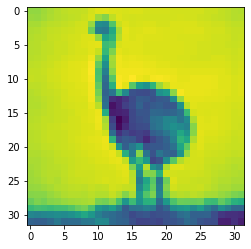

In [15]:
plt.imshow(gray[1][0].cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


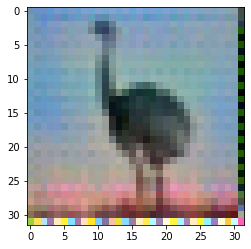

In [16]:
z = np.transpose(fake_image[1].cpu().detach().numpy(), (1,2,0))
plt.imshow(z)

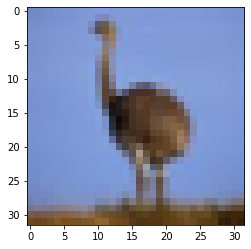

In [17]:
plt.imshow(img[1])

In [0]:
utils.save_image(fake_image, 'colored.png')

In [0]:
utils.save_image(gray, 'gray.png')

In [0]:
torch.save(generator.state_dict(), '/content/gdrive/My Drive/ImageColorization/generator.pt')

In [0]:
torch.save(discriminator.state_dict(), '/content/gdrive/My Drive/ImageColorization/discriminator.pt')